In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import function_library_assignment_2 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['axes.axisbelow'] = True

In [2]:
random.seed(2) #seed to ensure that we can get the same random values again
wind_scenarios = random.sample(range(100), 50) #How many scenarios? Sampling without replacement - taking 100 samples will just get a list from 0 to 99
wind_scenarios.sort()
#wind_scenarios

In [3]:
wind_hour = 31
n_bus = 24
gen_data = fnc.read_data('gen_data')
system_demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')
gen_costs = fnc.read_data('gen_costs')[['C ($/MWh)', 'C+($/MWh)', 'C-($/MWh)']]
#line_data = fnc.read_data('line_data')
#branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=wind_scenarios) #The ED is only for a single hour - in this case, we choose hour 31

In [4]:
wind_data

,V4,V5,V8,V9,V11,V12,V21,V22,V23,V24,...,V87,V88,V91,V92,V94,V95,V96,V97,V99,Expected
Wind Farm,,,,,,,,,,,,,,,,,,,,,
1,57.28,77.72,54.77,88.26,61.53,110.61,71.05,77.94,115.27,57.29,...,69.48,70.44,69.20,72.38,49.65,133.94,145.62,104.54,67.36,87.84
2,54.45,36.67,82.92,118.74,74.31,172.25,46.52,91.44,95.29,71.93,...,23.53,90.80,172.27,76.48,54.13,65.01,119.32,93.82,76.89,84.95
3,82.77,22.09,159.62,119.69,131.08,189.10,74.89,50.63,71.08,69.60,...,90.58,103.93,83.01,73.25,152.92,76.48,109.01,62.66,159.71,95.18
4,36.10,59.74,104.59,126.92,93.21,155.17,90.25,54.32,60.76,64.77,...,115.05,92.78,93.59,52.61,119.34,59.24,180.08,45.01,105.68,94.18
5,30.09,52.93,40.39,50.97,60.83,66.38,71.84,52.53,37.53,43.59,...,76.27,22.96,115.22,29.54,20.28,37.58,36.29,58.14,20.20,53.94
6,3.27,21.48,34.24,41.17,23.60,42.66,65.36,85.24,83.09,10.33,...,1.33,5.31,17.47,45.18,61.70,100.68,26.37,41.55,57.98,54.71


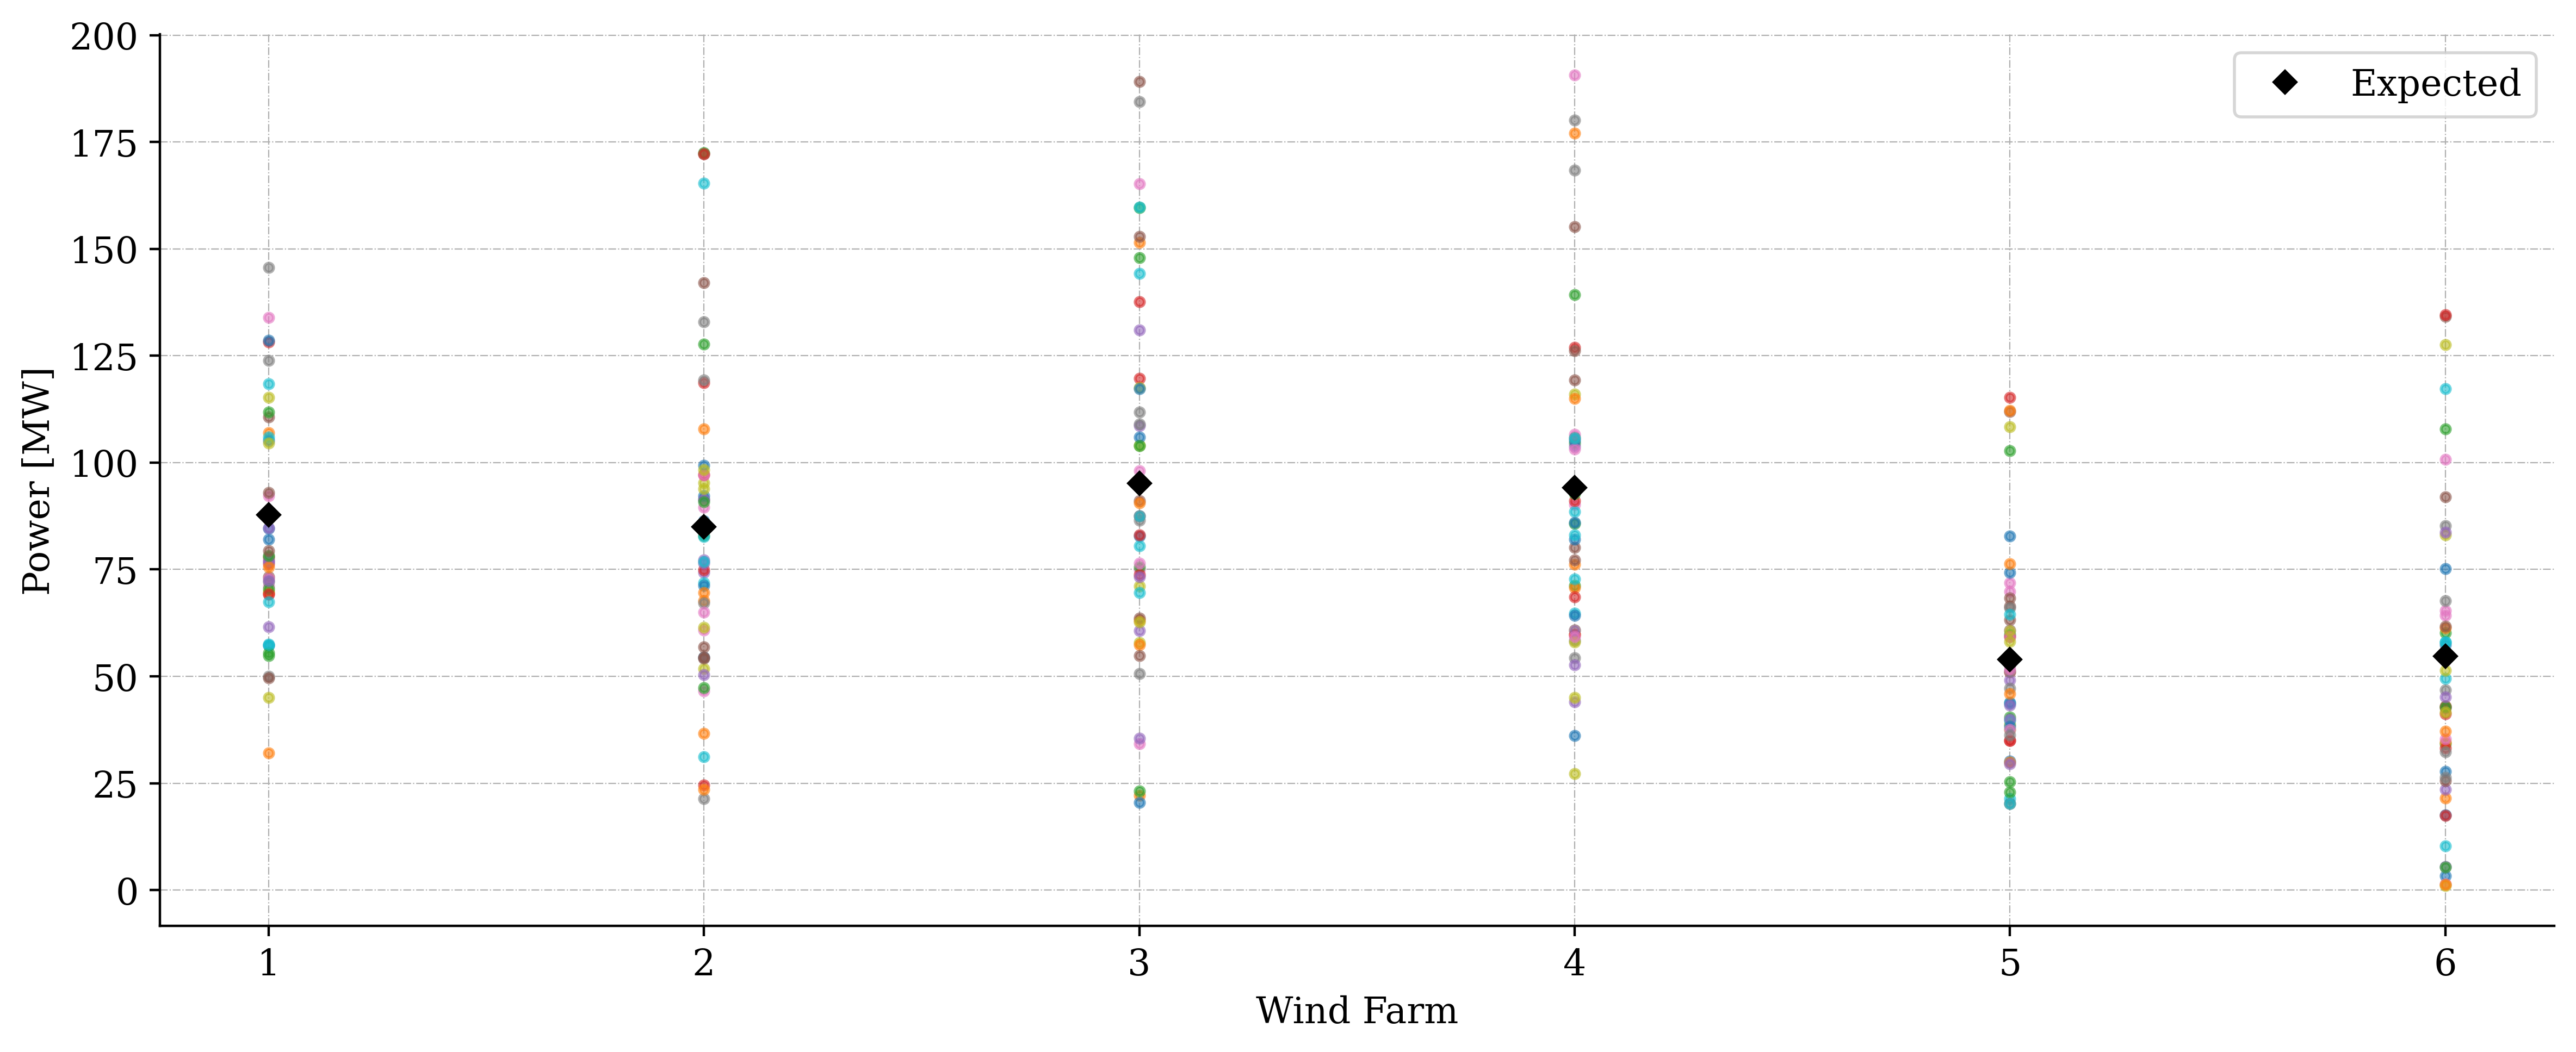

In [5]:
fig = plt.figure(figsize=( 12 , 5 ), dpi=400) # Create the figure
ax = fig.gca()
i = 1

for n in range(2):
    for k in range(3):
        ax.plot(wind_data.loc[wind_data.index == i][wind_data.columns[:-1].to_numpy()], alpha=0.6, linestyle='', marker='o', markersize=3)
        #ax.spines[['right', 'top']].set_visible(True)
        ax.plot(wind_data.loc[wind_data.index == i,'Expected'], color='black', linestyle='', marker='D', markersize=5)
        #ax.set_title('Wind Farm %d' % (i))

        i += 1
        ax.set_xlabel('Wind Farm')

    ax.set_ylabel('Power [MW]')

ax.plot(wind_data.loc[wind_data.index == i,'Expected'], color='black', linestyle='', marker='D', label = 'Expected', markersize=5)
plt.legend(loc = 'upper right')

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/wind_data_hour.png')
plt.show()

Assumption: Based on the exercises, we set the day-ahead cost of the wind farm to be 5% of the average cost of the gens and the regulation cost to be 10% of the average regulation cost of the gens

In [6]:
wf_costs = gen_costs.iloc[0:6].copy()
wf_costs['C ($/MWh)'] = 0.05 * gen_costs['C ($/MWh)'].mean()
wf_costs['C+($/MWh)'] = 0.1 * gen_costs['C+($/MWh)'].mean()
wf_costs['C-($/MWh)'] = 0.1 * gen_costs['C-($/MWh)'].mean()
wf_costs

,C ($/MWh),C+($/MWh),C-($/MWh)
0,0.62,1.41,0.90
1,0.62,1.41,0.90
2,0.62,1.41,0.90
3,0.62,1.41,0.90
4,0.62,1.41,0.90
5,0.62,1.41,0.90


"The commitment and ramping constraints and costs of all generators can be neglected."

In [7]:
gen_data = gen_data[['Unit #', 'Node', 'P max MW', 'R+ MW',	'R- MW']]
gen_data

,Unit #,Node,P max MW,R+ MW,R- MW
0,1,1,152,40,40
1,2,2,152,40,40
2,3,7,350,70,70
3,4,13,591,180,180
4,5,15,60,60,60
5,6,15,155,30,30
6,7,16,155,30,30
7,8,18,400,0,0
8,9,21,400,0,0
9,10,22,300,0,0


# Task 1b - Stochastic

### Setup model and solve

In [8]:
t = 0 #hour
demand = system_demand[t]

n_gen = len(gen_data.index)
n_wf = len(wind_data.index)
n_scenarios = len(wind_scenarios)
p_max_wf = 300

In [9]:
gen_data

,Unit #,Node,P max MW,R+ MW,R- MW
0,1,1,152,40,40
1,2,2,152,40,40
2,3,7,350,70,70
3,4,13,591,180,180
4,5,15,60,60,60
5,6,15,155,30,30
6,7,16,155,30,30
7,8,18,400,0,0
8,9,21,400,0,0
9,10,22,300,0,0


Setup dictionary to save results for multiple approaches

In [34]:
P_G_dispatch = {}
P_W_dispatch = {}

Run model

In [35]:
direction = gb.GRB.MINIMIZE #Min / Max

# Create a Gurobi model
m = gb.Model()
m.setParam("OutputFlag", 0)

# Add variables
p_G = m.addVars(n_gen, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in MW
p_W = m.addVars(n_wf, lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: Wind farms can be curtailed
p_G_UP = m.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = gb.quicksum(gen_costs['C ($/MWh)'][g] * p_G[g] for g in range(n_gen)) + gb.quicksum(wf_costs['C ($/MWh)'][w] * p_W[w] for w in range(n_wf)) + 1 / n_scenarios * (
                      gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios))
                      + gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))
                      )

m.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Day-ahead balance constraint
m.addConstr(gb.quicksum(p_G[g] for g in range(n_gen)) + gb.quicksum(p_W[w] for w in range(n_wf)) - demand == 0)

#Real-time balance constraint
m.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Output day-ahead limits
m.addConstrs(p_G[g] <= gen_data['P max MW'][g] for g in range(n_gen))

#Real-time limits
m.addConstrs(p_G[g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_W[w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m.addConstrs(p_G[g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_W[w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= wind_data[wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #accounting for wind scenario

#Real-time regulating power bounds
m.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m.update()
#m.display()

m.optimize()

### Analyze results

In [36]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {} #to be included: branch flows, theta, generator outputs
    generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values
    generator_outputs['Loading Percentage'] = 0

    wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W'])
    wf_outputs['Node'] = wf_costs.index + 1
    wf_outputs['Loading Percentage'] = 0
    wf_outputs['Expected Production'] = wind_data['Expected'].values

    constraints = m.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m.objVal)

    for i in range(n_gen):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x
        gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
        generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100

    for i in range(n_wf):
        print(p_W[i].VarName + ": %.2f MW" % p_W[i].x)
        wf_outputs.loc[wf_outputs.index == i, 'p_W'] = p_W[i].x
        wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100

    for k in range(0, (1 + n_scenarios + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind = sum(p_W[n].x for n in range(n_wf))
    sum_gen = sum(p_G[n].x for n in range(n_gen))
    sum_production = sum_wind + sum_gen
    print("\nTotal load: %.1f MWh" % demand)
    print("Total generation: %.1f MWh" % sum_production)

    results['gen'] = generator_outputs.copy(deep=True)
    results['wind'] = wf_outputs.copy(deep=True)

else:
    print("Optimization was not successful.")     

P_G_dispatch['STOCHASTIC'] = {g: p_G[g].x for g in range(n_gen)}
P_W_dispatch['STOCHASTIC'] = {w: p_W[w].x for w in range(n_wf)}

-----------------------------------------------
Optimal objective value: 7567.75 $
P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 30.00 MW
P_G[6]: 30.00 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 119.15 MW
P_G[11]: 40.00 MW
P_W[0]: 79.41 MW
P_W[1]: 86.37 MW
P_W[2]: 95.56 MW
P_W[3]: 91.03 MW
P_W[4]: 52.93 MW
P_W[5]: 51.39 MW
Dual value 1:  10.52
Dual value 2:  0.32
Dual value 3:  0.32
Dual value 4:  0.16
Dual value 5:  0.16
Dual value 6:  0.28
Dual value 7:  0.02816666666666667
Dual value 8:  0.28
Dual value 9:  0.28
Dual value 10:  0.16
Dual value 11:  0.3
Dual value 12:  0.3
Dual value 13:  0.14
Dual value 14:  0.16
Dual value 15:  0.32
Dual value 16:  0.16
Dual value 17:  0.02816666666666667
Dual value 18:  0.14
Dual value 19:  0.32
Dual value 20:  0.3
Dual value 21:  0.14
Dual value 22:  0.16
Dual value 23:  0.3
Dual value 24:  0.3
Dual value 25:  0.28
Dual value 26:  0.3
Dual value 27:  0.3
Dual value 28:  0.3
Dual val

3 x 6 with loading plots at the bottom and wind included next to generators


In [39]:
results.get('gen')

,p_G,Node,Loading Percentage
0,0.00,1,0.00
1,0.00,2,0.00
2,0.00,7,0.00
3,0.00,13,0.00
4,0.00,15,0.00
5,30.00,15,19.35
6,30.00,16,19.35
7,400.00,18,100.00
8,400.00,21,100.00
9,300.00,22,100.00


In [40]:
gen_costs

,C ($/MWh),C+($/MWh),C-($/MWh)
0,13.32,15.00,11.00
1,13.32,15.00,11.00
2,20.70,24.00,16.00
3,20.93,25.00,17.00
4,26.11,28.00,23.00
5,10.52,16.00,7.00
6,10.52,16.00,7.00
7,6.02,0.00,0.00
8,5.47,0.00,0.00
9,0.00,0.00,0.00


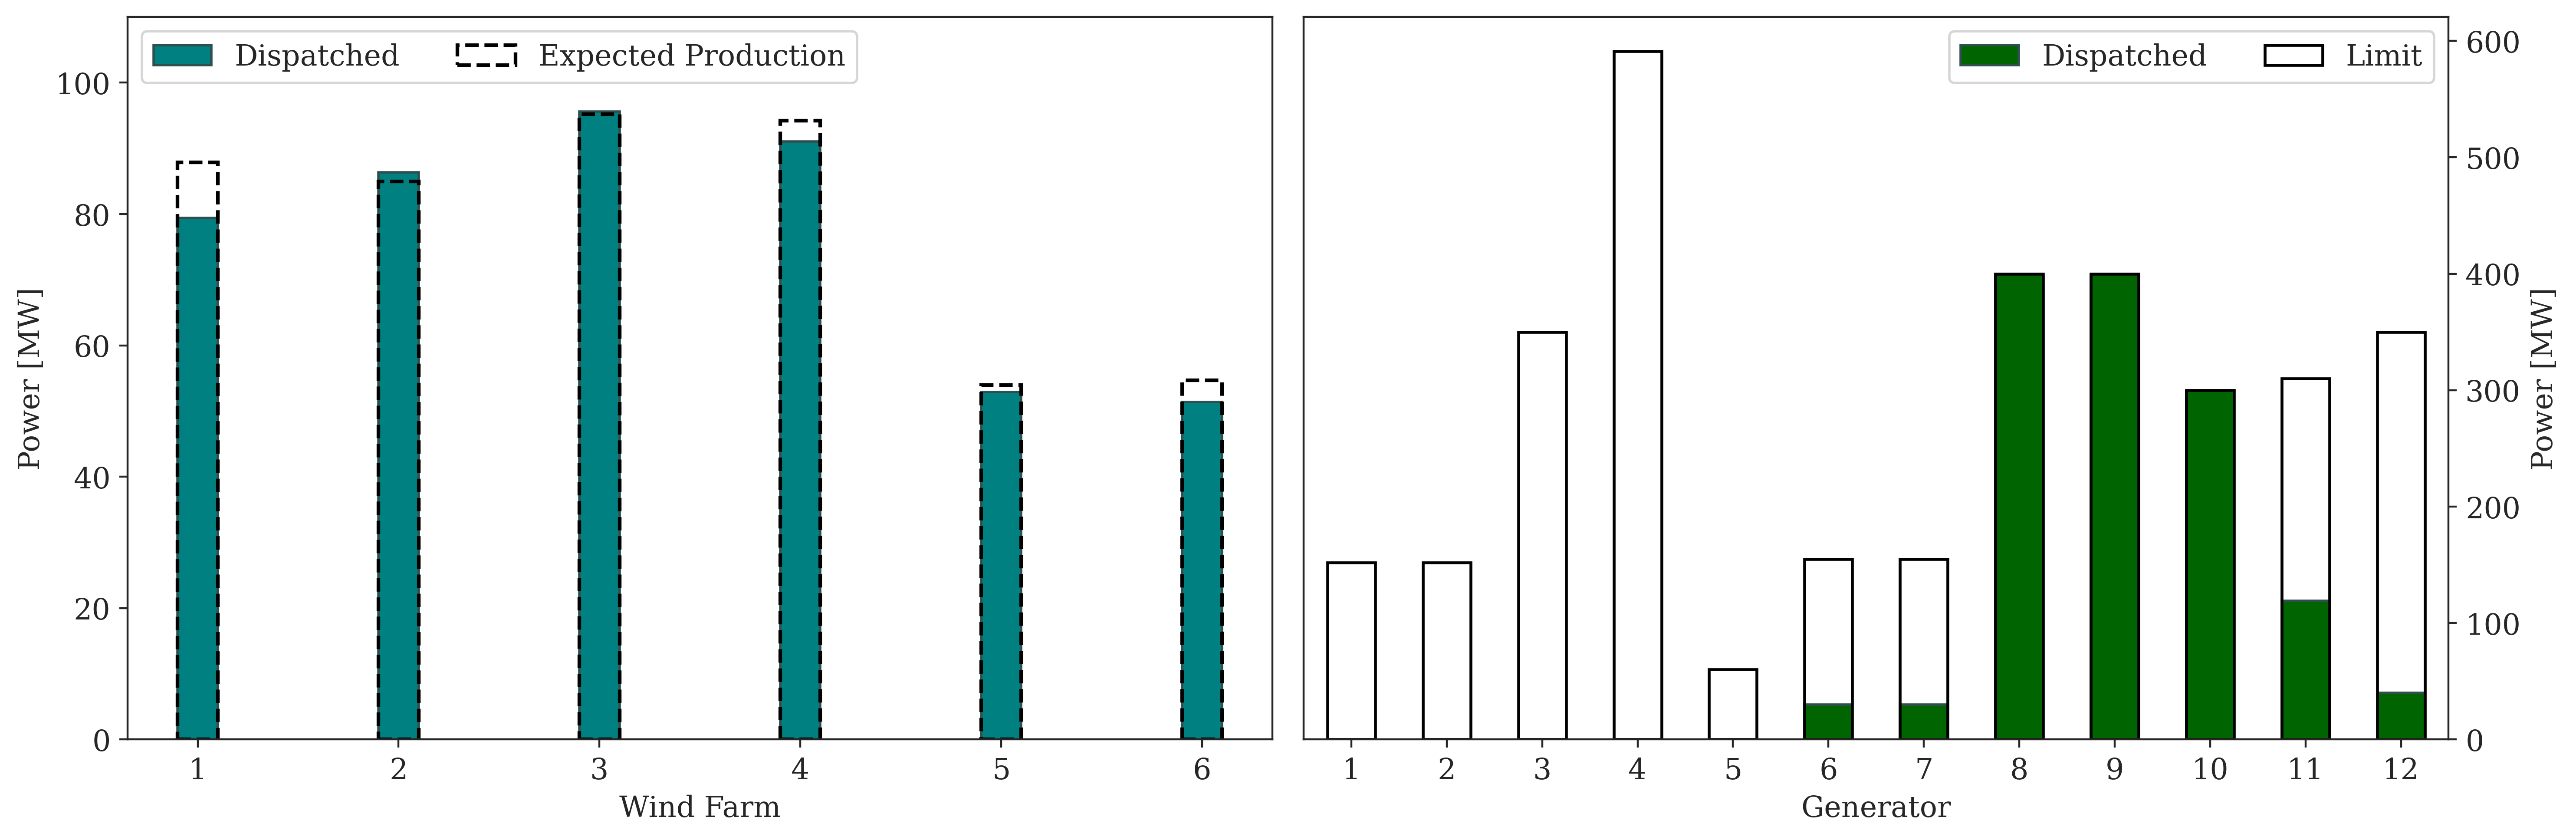

In [41]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

(results.get('wind')['p_W']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
(results.get('wind')['Expected Production']).plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,110])

(results.get('gen')['p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
#((results.get('gen')['p_G']) / ((results.get('gen')['Loading Percentage']) / 100)).plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/task_1_results_gen_dispatch.png',bbox_inches='tight')
plt.show()

## Profit and cost-recovery analysis

In [42]:
#Uniform day-ahead price in $ is the dual value of the balance constraint
uniform_price_DA = dual_values[0]
DA_profits = {}

# Day-ahead dispatch
print('Day-ahead profits with uniform price %.2f $\n' % uniform_price_DA)
for g in range(n_gen):
    revenue = results.get('gen')['p_G'][g] * uniform_price_DA
    cost = results.get('gen')['p_G'][g] * gen_costs['C ($/MWh)'][g]
    profit = revenue - cost
    print('------------')
    print(f'Generator {g + 1}:')
    print('Dispatch: %.2f MW' % results.get('gen')['p_G'][g])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    DA_profits['G%d' % (g + 1)] = profit

for w in range(n_wf):
    revenue = results.get('wind')['p_W'][w] * uniform_price_DA
    cost = results.get('wind')['p_W'][w] * wf_costs['C ($/MWh)'][w]
    profit = revenue - cost
    print('------------')
    print(f'Wind Farm {w + 1}:')
    print('Dispatch: %.2f MW' % results.get('wind')['p_W'][w])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    DA_profits['WF%d' % (w + 1)] = profit

Day-ahead profits with uniform price 10.52 $

------------
Generator 1:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 2:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 3:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 4:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 5:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 6:
Dispatch: 30.00 MW
Revenue: 315.60 $
Cost: 315.60 $
Profit: 0.00 $
------------
Generator 7:
Dispatch: 30.00 MW
Revenue: 315.60 $
Cost: 315.60 $
Profit: 0.00 $
------------
Generator 8:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2408.00 $
Profit: 1800.00 $
------------
Generator 9:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2188.00 $
Profit: 2020.00 $
------------
Generator 10:
Dispatch: 300.00 MW
Revenue: 3156.00 $
Cost: 0.00 $
Profit: 3156.00 $
------------
Generator 11:
Dispat

In [43]:
# In each scenario, we can compute the profits with the up- and down-regulation power
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

real_time_profits = pd.DataFrame(data=np.zeros(n_scenarios), columns=['WF1'])
real_time_profits.index.name = 'Scenario'

for w in range(n_wf):
    real_time_profits['WF%d' % (w + 1)] = 0
for g in range(n_gen):
    real_time_profits['G%d' % (g + 1)] = 0

for n in range(n_scenarios):
    #the dual value of the constraint is the sensitivity of the objective function with respect to the constraint
    #since the objective function second stage term is weighted by the scenario probabilities (in this case uniform),
    #the actual price is reflected by the dual value times the number of scenarios (notice the 1/n_scenarios term in the objective function)
    adjustment_price = dual_values[n + 1] * n_scenarios 
    print('------------------------------------------')
    print('Scenario %d - real time adjustment cost of %.2f $' % (n + 1, adjustment_price))

    for g in range(n_gen):

        profit = p_G_UP[g,n].x * (adjustment_price - gen_costs['C+($/MWh)'][g]) + p_G_DOWN[g,n].x * (gen_costs['C-($/MWh)'][g] - adjustment_price)
        
        print('------------')
        print(f'Generator {g + 1}')
        print('Adjustment: %.2f MW' % ( p_G_UP[g,n].x - p_G_DOWN[g,n].x))
        print('Real-time Profit: %.2f $' % profit)

        real_time_profits.loc[real_time_profits.index == n,'G%d' % (g + 1)] = profit

    for w in range(n_wf):

        profit = p_W_UP[w,n].x * (adjustment_price - wf_costs['C+($/MWh)'][w]) + p_W_DOWN[w,n].x * (wf_costs['C-($/MWh)'][w] - adjustment_price)

        print('------------')
        print(f'Wind Farm {w + 1}')
        print('Day-ahead dispatch: %.2f MW' % results.get('wind')['p_W'][w])
        print('Realized power: %.2f MW' % (wind_data[wind_data.columns[n]].iloc[w]))
        print('Adjustment: %.2f MW' % ( p_W_UP[w,n].x - p_W_DOWN[w,n].x))
        print('Real-time Profit: %.2f $' % profit)

        real_time_profits.loc[real_time_profits.index == n,'WF%d' % (w + 1)] = profit
    

------------------------------------------
Scenario 1 - real time adjustment cost of 16.00 $
------------
Generator 1
Adjustment: 40.00 MW
Real-time Profit: 40.00 $
------------
Generator 2
Adjustment: 40.00 MW
Real-time Profit: 40.00 $
------------
Generator 3
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 4
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 5
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 6
Adjustment: 30.00 MW
Real-time Profit: 0.00 $
------------
Generator 7
Adjustment: 22.73 MW
Real-time Profit: 0.00 $
------------
Generator 8
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 9
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 10
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 11
Adjustment: 60.00 MW
Real-time Profit: 120.00 $
------------
Generator 12
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Wind Farm 1
Day-ahead dispatch: 79.41 MW
R

In [44]:
total_profits = real_time_profits.copy(deep=True)

for col in list(real_time_profits.columns):
    total_profits[col] = total_profits[col].values + DA_profits[col]

total_profits

,WF1,WF2,WF3,WF4,WF5,WF6,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12
Scenario,,,,,,,,,,,,,,,,,,
0,452.21,373.23,753.04,71.89,179.22,-217.74,40.00,40.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,120.00,-14.80
1,760.73,104.72,-163.20,428.90,524.08,57.24,40.00,40.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,120.00,-14.80
2,611.36,830.76,1368.53,990.74,435.10,387.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
3,844.66,1068.61,1105.28,1137.96,510.18,436.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
4,552.04,697.31,1393.51,928.78,623.58,144.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
5,786.32,855.22,946.23,901.34,524.08,504.44,0.00,0.00,0.00,0.00,0.00,167.75,167.75,1800.00,2020.00,3156.00,395.50,248.87
6,676.78,333.26,675.47,891.12,762.26,684.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
7,767.08,919.06,357.63,420.50,518.87,935.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
8,1022.67,914.06,772.44,686.45,414.80,717.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80


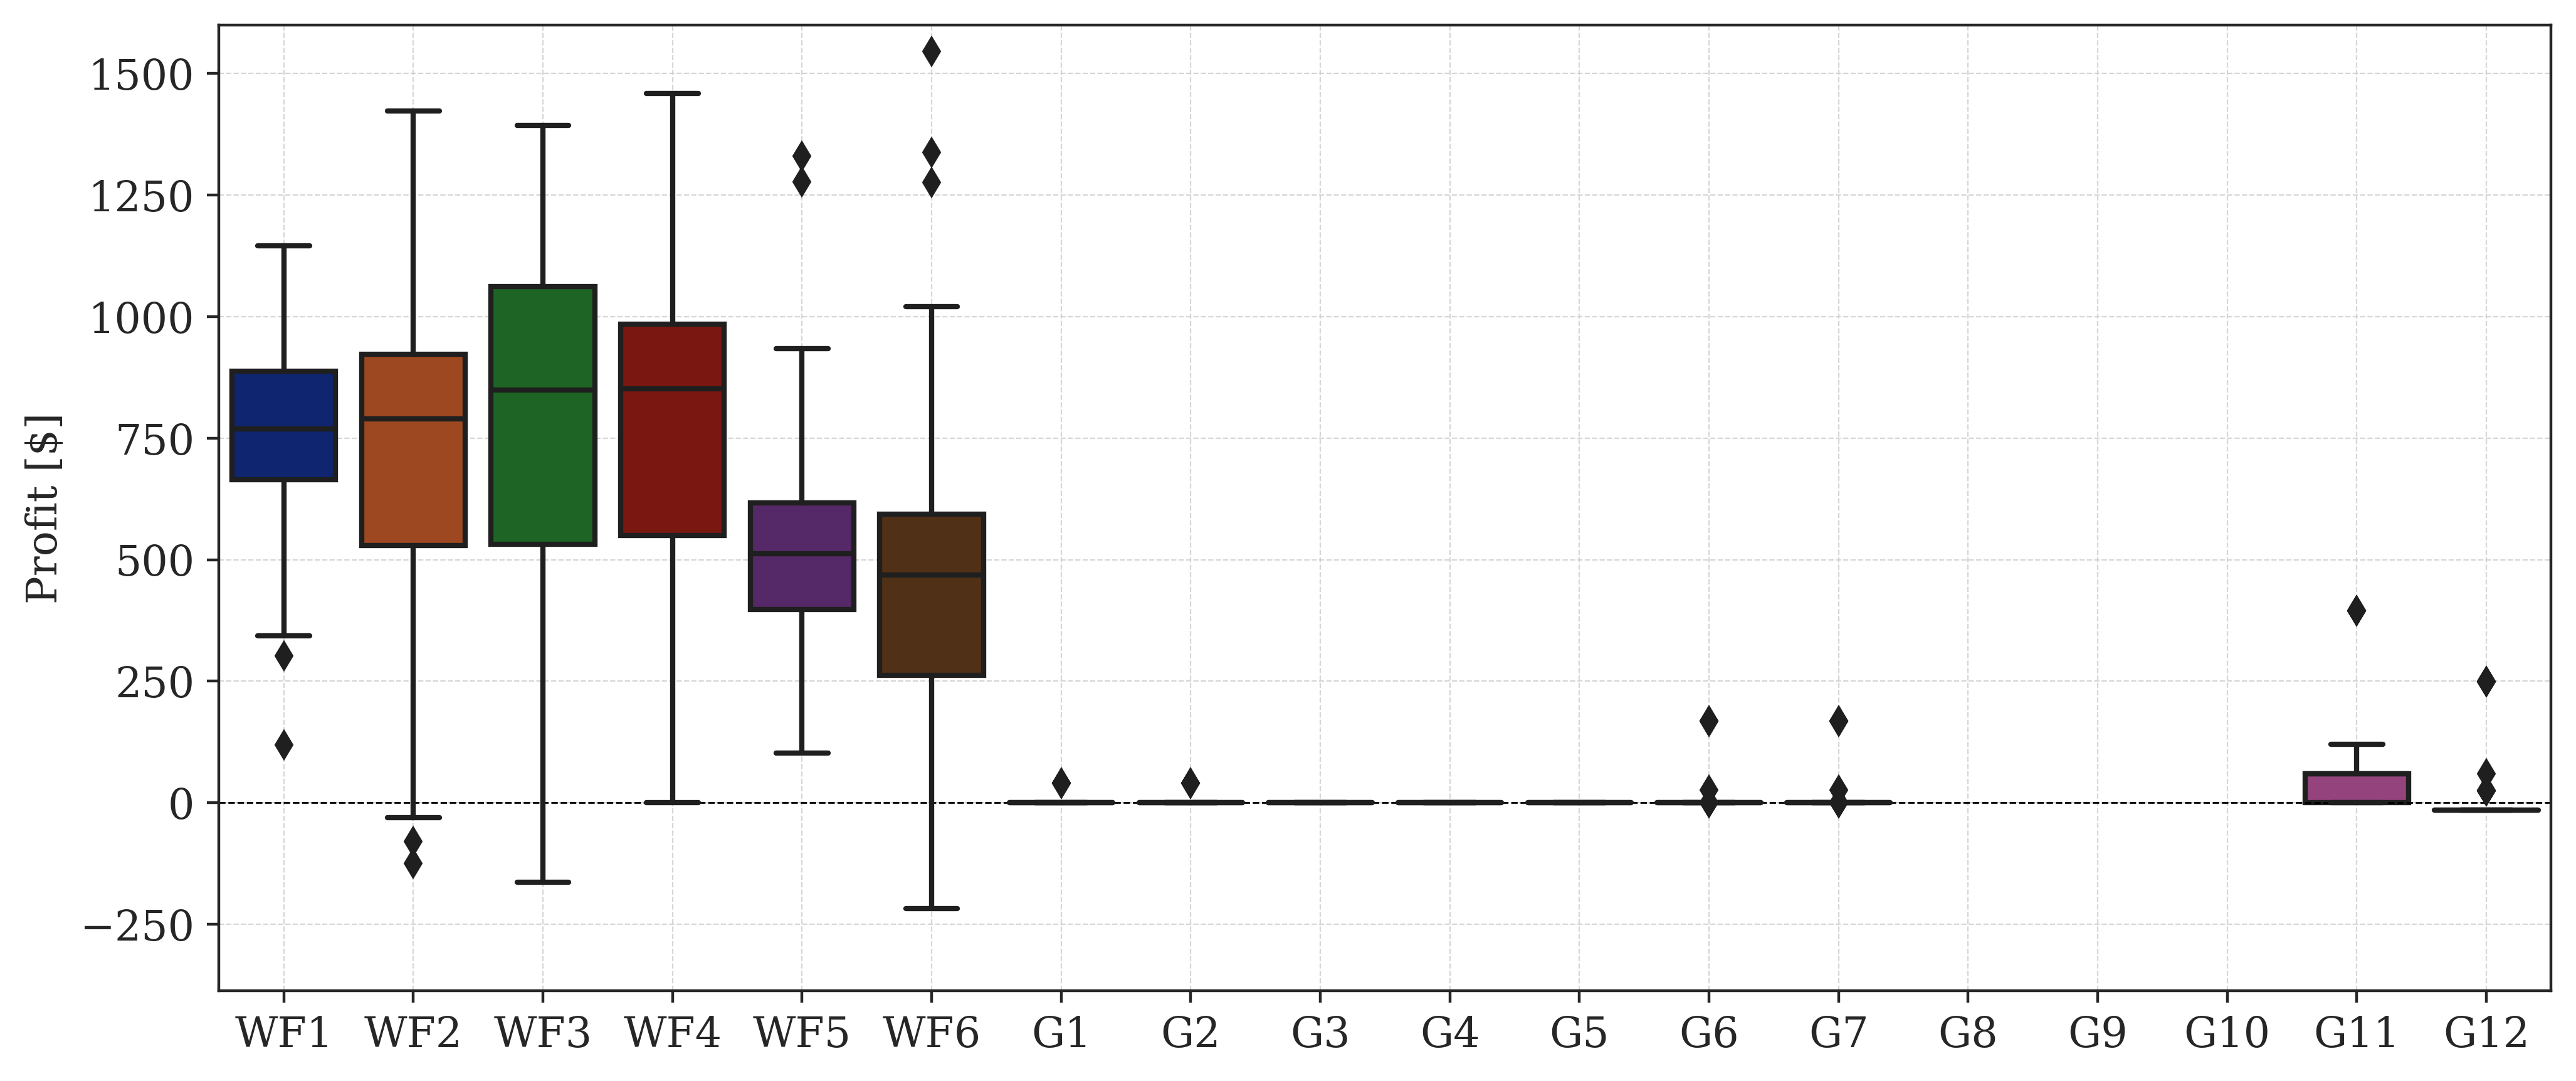

In [18]:
sns.set_style("ticks")
sns.set_style({'font.family':'serif'})
plt.figure(figsize=(12,5), dpi=400)

sns.boxplot(total_profits, zorder=5, palette='dark')

plt.ylim(ymax=1600)
plt.grid(linestyle='--', alpha=0.8, zorder=0)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Profit [$]')


ax = fig.gca()
ax.set_axisbelow(True)

#plt.savefig('Figures/profit_distribution.png', bbox_inches='tight')
plt.show()

In [61]:
day_ahead_cost = 0

for g in range(n_gen):
    day_ahead_cost += P_G_dispatch['STOCHASTIC'][g] * gen_costs['C ($/MWh)'][g]

for w in range(n_wf):
    day_ahead_cost += P_W_dispatch['STOCHASTIC'][w] * wf_costs['C ($/MWh)'][w]

print('Stochastic day-ahead dispatch cost: %.2f $' % day_ahead_cost)

Stochastic day-ahead dispatch cost: 7198.52 $


# Task 1c - Deterministic

For this approach, we choose the average value of the samples - not the overall average of all samples

In [19]:
mean_wind = wind_data[wind_data.columns[:-1]].mean(axis=1)

In [20]:
wind_data['Expected']

Wind Farm
1   87.84
2   84.95
3   95.18
4   94.18
5   53.94
6   54.71
Name: Expected, dtype: float64

In-sample average is different:

In [21]:
mean_wind

Wind Farm
1   83.14
2   83.75
3   94.50
4   91.14
5   54.44
6   50.96
dtype: float64

In [45]:
m.dispose()

direction = gb.GRB.MINIMIZE #Min / Max

# Create a Gurobi model
m_d = gb.Model()
m_d.setParam("OutputFlag", 0)

# Add variables
p_G = m_d.addVars(n_gen, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in MW
p_W = m_d.addVars(n_wf, lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: Wind farms can be curtailed


# Set objective function
obj = gb.quicksum(gen_costs['C ($/MWh)'][g] * p_G[g] for g in range(n_gen)) + gb.quicksum(wf_costs['C ($/MWh)'][w] * p_W[w] for w in range(n_wf))

m_d.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Day-ahead balance constraint
m_d.addConstr(gb.quicksum(p_G[g] for g in range(n_gen)) + gb.quicksum(p_W[w] for w in range(n_wf)) - demand == 0)

#Output day-ahead limits
m_d.addConstrs(p_G[g] <= gen_data['P max MW'][g] for g in range(n_gen))
m_d.addConstrs(p_W[w] <= mean_wind.values[w] for w in range(n_wf))

m_d.update()
#m.display()

m_d.optimize()


In [46]:
#Print solutions
if m_d.status == gb.GRB.OPTIMAL:
    results_deterministic = {} #to be included: branch flows, theta, generator outputs
    generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values
    generator_outputs['Loading Percentage'] = 0

    wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W'])
    wf_outputs['Node'] = wf_costs.index + 1
    wf_outputs['Loading Percentage'] = 0
    wf_outputs['Expected Production'] = mean_wind.values

    constraints = m_d.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m_d.objVal)

    for i in range(n_gen):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x
        gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
        generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100

    for i in range(n_wf):
        print(p_W[i].VarName + ": %.2f MW" % p_W[i].x)
        wf_outputs.loc[wf_outputs.index == i, 'p_W'] = p_W[i].x
        wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100

    for k in range(0, (1 + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind = sum(p_W[n].x for n in range(n_wf))
    sum_gen = sum(p_G[n].x for n in range(n_gen))
    sum_production = sum_wind + sum_gen
    print("\nTotal load: %.1f MWh" % demand)
    print("Total generation: %.1f MWh" % sum_production)

    results_deterministic['gen'] = generator_outputs.copy(deep=True)
    results_deterministic['wind'] = wf_outputs.copy(deep=True)

else:
    print("Optimization was not successful.")     

P_G_dispatch['DETERMINISTIC'] = {g: p_G[g].x for g in range(n_gen)}
P_W_dispatch['DETERMINISTIC'] = {w: p_W[w].x for w in range(n_wf)}

-----------------------------------------------
Optimal objective value: 7171.33 $
P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 0.00 MW
P_G[6]: 0.00 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 217.90 MW
P_G[11]: 0.00 MW
P_W[0]: 83.14 MW
P_W[1]: 83.75 MW
P_W[2]: 94.50 MW
P_W[3]: 91.14 MW
P_W[4]: 54.44 MW
P_W[5]: 50.96 MW
Dual value 1:  10.52
Dual value 2:  0.0
Dual value 3:  0.0
Dual value 4:  0.0
Dual value 5:  0.0
Dual value 6:  0.0
Dual value 7:  0.0
Dual value 8:  0.0
Dual value 9:  -4.5
Dual value 10:  -5.05
Dual value 11:  -10.52
Dual value 12:  0.0
Dual value 13:  0.0

Total load: 1775.8 MWh
Total generation: 1775.8 MWh


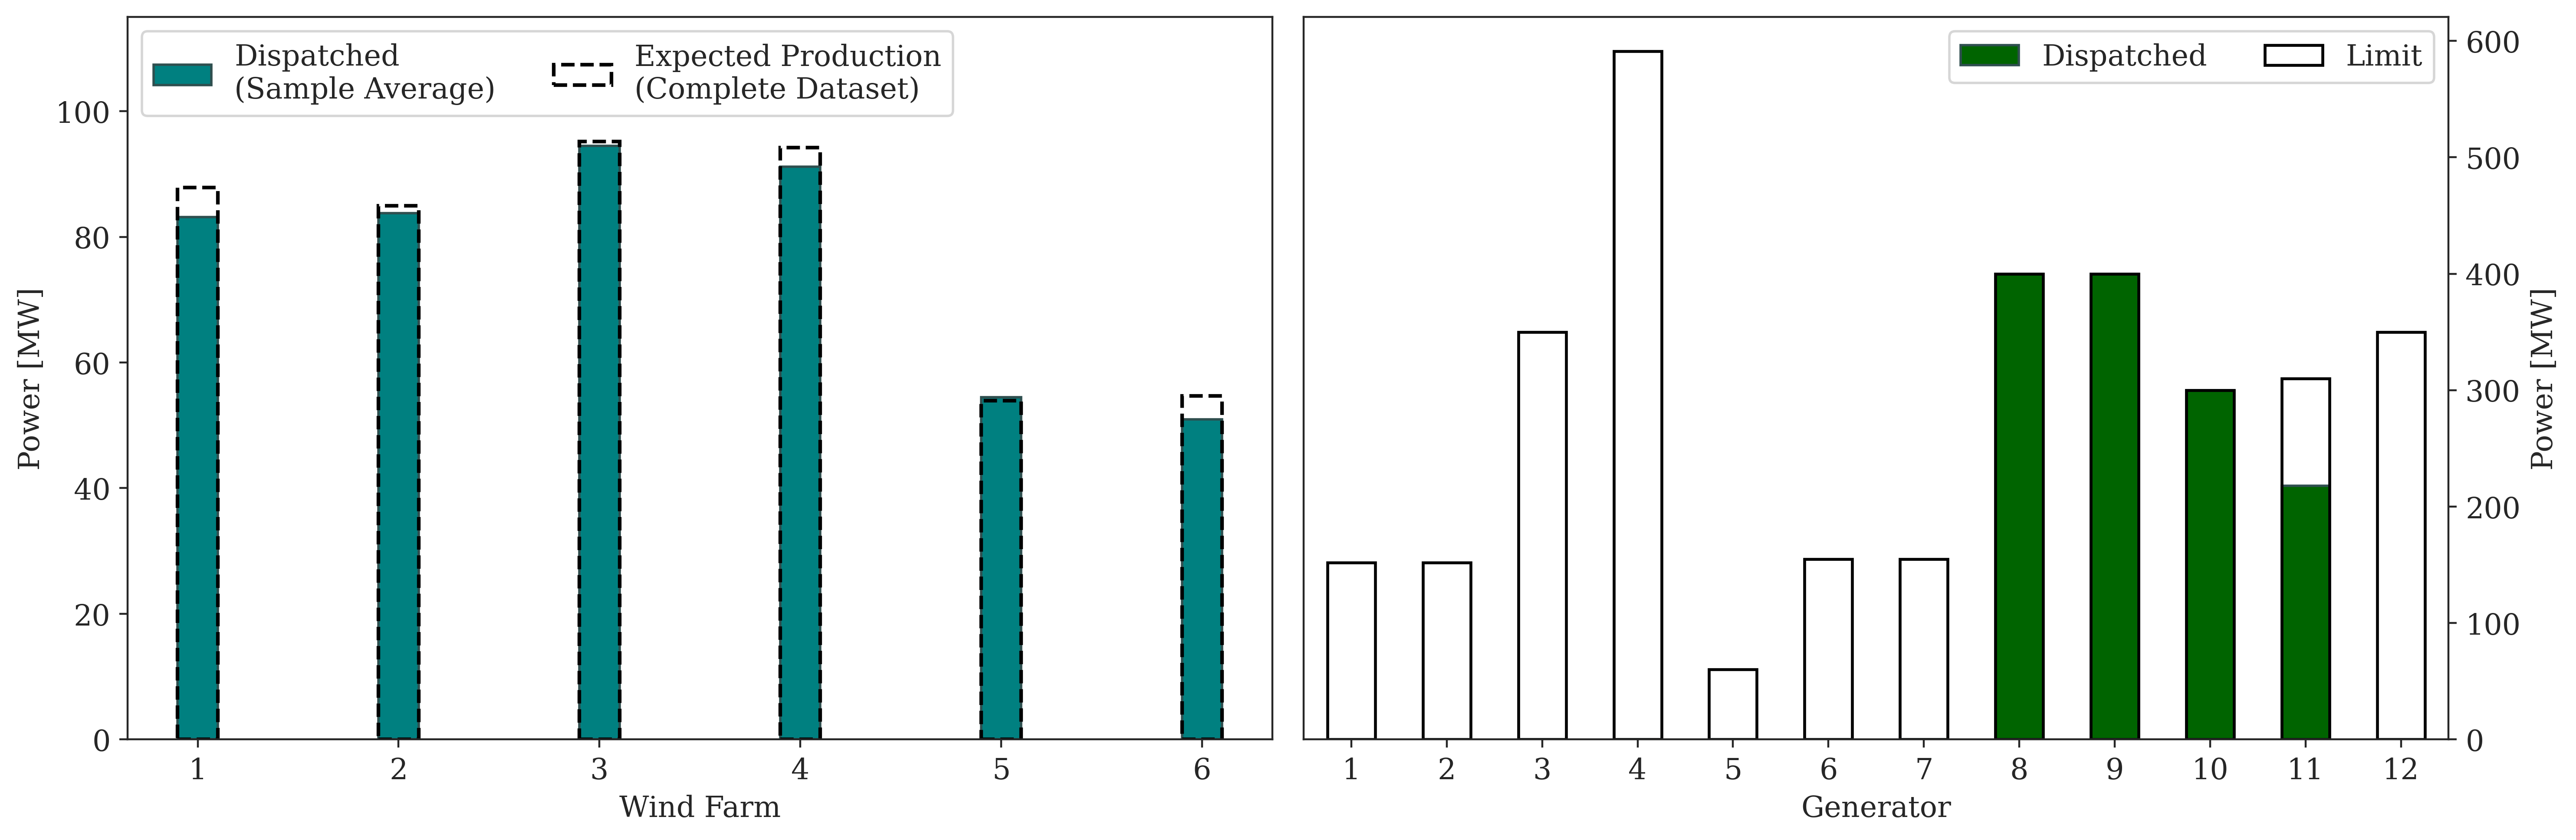

In [24]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

(results_deterministic.get('wind')['p_W']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched\n(Sample Average)', edgecolor='darkslategrey')
(results.get('wind')['Expected Production']).plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production\n(Complete Dataset)')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,115])

(results_deterministic.get('gen')['p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
#((results.get('gen')['p_G']) / ((results.get('gen')['Loading Percentage']) / 100)).plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/task_1_results_gen_dispatch_deterministic_day_ahead.png',bbox_inches='tight')
plt.show()

# Task 1d - Real-time Adjustments

### Out-of-sample adjustment performance

Be aware: "please solve the real-time re-dispatch problem for each remaining wind
power scenario from the original dataset used in Question b (out-of-sample)."

In [25]:
np.array(wind_scenarios)

array([ 3,  4,  7,  8, 10, 11, 20, 21, 22, 23, 27, 28, 29, 30, 32, 34, 35,
       39, 40, 43, 46, 47, 48, 50, 54, 55, 56, 57, 58, 59, 60, 62, 64, 65,
       67, 69, 74, 77, 81, 82, 85, 86, 87, 90, 91, 93, 94, 95, 96, 98])

In [26]:
out_of_sample_scenarios = np.setxor1d(np.array(wind_scenarios), np.arange(100))
out_of_sample_scenarios

array([ 0,  1,  2,  5,  6,  9, 12, 13, 14, 15, 16, 17, 18, 19, 24, 25, 26,
       31, 33, 36, 37, 38, 41, 42, 44, 45, 49, 51, 52, 53, 61, 63, 66, 68,
       70, 71, 72, 73, 75, 76, 78, 79, 80, 83, 84, 88, 89, 92, 97, 99])

In [27]:
out_of_sample_wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=out_of_sample_scenarios).drop(columns=['Expected'])
out_of_sample_wind_data

,V1,V2,V3,V6,V7,V10,V13,V14,V15,V16,...,V79,V80,V81,V84,V85,V89,V90,V93,V98,V100
Wind Farm,,,,,,,,,,,,,,,,,,,,,
1,129.71,167.67,56.95,130.53,88.15,134.49,35.91,65.70,75.04,55.01,...,69.80,41.44,103.84,74.49,91.31,60.89,103.88,83.37,57.31,66.15
2,149.91,81.91,21.47,64.63,81.76,129.80,80.76,66.73,48.09,104.24,...,68.94,20.66,89.30,67.85,73.00,93.37,92.95,43.40,47.16,52.26
3,140.28,145.61,35.52,151.28,78.23,85.96,73.62,108.29,98.08,21.13,...,108.38,63.95,113.89,62.98,67.69,67.70,103.23,62.76,40.34,39.86
4,137.33,91.46,68.42,82.04,66.49,157.77,73.92,86.03,97.91,66.87,...,163.20,23.01,102.68,83.91,94.22,97.68,156.00,47.74,57.55,68.38
5,63.42,58.30,85.68,28.73,20.65,47.52,30.99,76.36,108.60,42.71,...,55.90,44.01,90.28,56.81,39.36,53.69,60.71,38.12,29.18,33.77
6,78.10,66.57,101.99,0.90,71.20,128.50,77.22,51.94,51.03,40.97,...,126.85,37.75,29.09,35.03,3.61,104.12,66.21,23.02,52.85,11.43


#### Stochastic

In [51]:
direction = gb.GRB.MINIMIZE #Min / Max
n_scenarios = len(out_of_sample_scenarios)

# Create a Gurobi model
m_ad = gb.Model()
m_ad.setParam("OutputFlag", 0)

# Add variables
p_G_UP = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = 1 / n_scenarios * gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios)) + 1 / n_scenarios * gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))

m_ad.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Real-time balance constraint
m_ad.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Real-time limits
m_ad.addConstrs(P_G_dispatch['STOCHASTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['STOCHASTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m_ad.addConstrs(P_G_dispatch['STOCHASTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['STOCHASTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= out_of_sample_wind_data[out_of_sample_wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #out of sample wind scenario

#Real-time regulating power bounds
m_ad.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m_ad.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m_ad.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m_ad.update()
#m.display()

m_ad.optimize()

In [55]:
#Print solutions
if m_ad.status == gb.GRB.OPTIMAL:
    adjustment_results_scenario = {}
    
    for k in range(n_scenarios):
        results_adjustment = {}
        generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G_UP'])
        generator_outputs['p_G_DOWN'] = 0
        generator_outputs['p_G_ADJUST'] = 0
        generator_outputs['Node'] = gen_data['Node'].values
        generator_outputs['Loading Percentage'] = 0

        wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W_UP'])
        wf_outputs['p_W_DOWN'] = 0
        wf_outputs['p_W_ADJUST'] = 0
        wf_outputs['Node'] = wf_costs.index + 1
        wf_outputs['Loading Percentage'] = 0
        wf_outputs['Expected Production'] = wind_data['Expected'].values

        constraints = m_ad.getConstrs()
        # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
        dual_values = [constraints[k].Pi for k in range(len(constraints))] 
        print('-----------------------------------------------')

        for i in range(n_gen):
            print(p_G_UP[i,k].VarName + ": %.2f MW" % p_G_UP[i,k].x)
            print(p_G_DOWN[i,k].VarName + ": %.2f MW" % p_G_DOWN[i,k].x)
            generator_outputs.loc[generator_outputs.index == i, 'p_G_UP'] = p_G_UP[i,k].x
            generator_outputs.loc[generator_outputs.index == i, 'p_G_DOWN'] = p_G_DOWN[i,k].x
            generator_outputs.loc[generator_outputs.index == i, 'p_G_ADJUST'] = p_G_UP[i,k].x - p_G_DOWN[i,k].x
            gen_limit_up = gen_data.loc[gen_data.index == i, 'R+ MW']
            gen_limit_dw = gen_data.loc[gen_data.index == i, 'R- MW']
            generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G_UP[i,k].x / gen_limit_up) * 100
            generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G_DOWN[i,k].x / gen_limit_dw) * 100

        for i in range(n_wf):
            print(p_W_UP[i,k].VarName + ": %.2f MW" % p_W_UP[i,k].x)
            print(p_W_DOWN[i,k].VarName + ": %.2f MW" % p_W_DOWN[i,k].x)
            wf_outputs.loc[wf_outputs.index == i, 'p_W_UP'] = p_W_UP[i,k].x
            wf_outputs.loc[wf_outputs.index == i, 'p_W_DOWN'] = p_W_DOWN[i,k].x
            wf_outputs.loc[wf_outputs.index == i, 'p_W_ADJUST'] = p_W_UP[i,k].x - p_W_DOWN[i,k].x
            wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W_UP[i,k].x / p_max_wf) * 100
            wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W_DOWN[i,k].x / p_max_wf) * 100

        results_adjustment['gen'] = generator_outputs.copy(deep=True)
        results_adjustment['wind'] = wf_outputs.copy(deep=True)
        adjustment_results_scenario[k] = results_adjustment.copy()


    for k in range(0, (1 + n_scenarios + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind_up = [sum(p_W_UP[n, k].x for n in range(n_wf)) for k in range(n_scenarios)]
    sum_wind_dw = [sum(p_W_DOWN[n, k].x for n in range(n_wf)) for k in range(n_scenarios)]
    sum_gen_up = [sum(p_G_UP[n, k].x for n in range(n_gen)) for k in range(n_scenarios)]
    sum_gen_dw = [sum(p_G_DOWN[n, k].x for n in range(n_gen)) for k in range(n_scenarios)]

    for k in range(n_scenarios):
        print(f"\nScenario {k+1}:")
        print("Total upward adjustment:", sum_wind_up[k] + sum_gen_up[k], "MW")
        print("Total downward adjustment:", sum_wind_dw[k] + sum_gen_dw[k], "MW")
    print('-----------------------------------------------')
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m_ad.objVal)

else:
    print("Optimization was not successful.")

-----------------------------------------------
p_G_UP[0,0]: 0.00 MW
p_G_DOWN[0,0]: 0.00 MW
p_G_UP[1,0]: 0.00 MW
p_G_DOWN[1,0]: 0.00 MW
p_G_UP[2,0]: 0.00 MW
p_G_DOWN[2,0]: 0.00 MW
p_G_UP[3,0]: 0.00 MW
p_G_DOWN[3,0]: 0.00 MW
p_G_UP[4,0]: 0.00 MW
p_G_DOWN[4,0]: 0.00 MW
p_G_UP[5,0]: 0.00 MW
p_G_DOWN[5,0]: 30.00 MW
p_G_UP[6,0]: 0.00 MW
p_G_DOWN[6,0]: 30.00 MW
p_G_UP[7,0]: 0.00 MW
p_G_DOWN[7,0]: 0.00 MW
p_G_UP[8,0]: 0.00 MW
p_G_DOWN[8,0]: 0.00 MW
p_G_UP[9,0]: 0.00 MW
p_G_DOWN[9,0]: 0.00 MW
p_G_UP[10,0]: 0.00 MW
p_G_DOWN[10,0]: 60.00 MW
p_G_UP[11,0]: 0.00 MW
p_G_DOWN[11,0]: 40.00 MW
p_W_UP[0,0]: 50.30 MW
p_W_DOWN[0,0]: 0.00 MW
p_W_UP[1,0]: 63.54 MW
p_W_DOWN[1,0]: 0.00 MW
p_W_UP[2,0]: 19.45 MW
p_W_DOWN[2,0]: 0.00 MW
p_W_UP[3,0]: 0.00 MW
p_W_DOWN[3,0]: 0.00 MW
p_W_UP[4,0]: 0.00 MW
p_W_DOWN[4,0]: 0.00 MW
p_W_UP[5,0]: 26.71 MW
p_W_DOWN[5,0]: 0.00 MW
-----------------------------------------------
p_G_UP[0,1]: 0.00 MW
p_G_DOWN[0,1]: 0.00 MW
p_G_UP[1,1]: 0.00 MW
p_G_DOWN[1,1]: 0.00 MW
p_G_UP[2,1]:

#### Deterministic

In [56]:
direction = gb.GRB.MINIMIZE #Min / Max
n_scenarios = len(out_of_sample_scenarios)

# Create a Gurobi model
m_ad = gb.Model()
m_ad.setParam("OutputFlag", 0)

# Add variables
p_G_UP = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = 1 / n_scenarios * gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios)) + 1 / n_scenarios * gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))

m_ad.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Real-time balance constraint
m_ad.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Real-time limits
m_ad.addConstrs(P_G_dispatch['DETERMINISTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['DETERMINISTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m_ad.addConstrs(P_G_dispatch['DETERMINISTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['DETERMINISTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= out_of_sample_wind_data[out_of_sample_wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #out of sample wind scenario

#Real-time regulating power bounds
m_ad.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m_ad.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m_ad.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m_ad.update()
#m.display()

m_ad.optimize()

#Print solutions
if m_ad.status == gb.GRB.OPTIMAL:
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m_ad.objVal)

else:
    print("Optimization was not successful.")

-----------------------------------------------
Optimal objective value: 507.85 $


## In-sample adjustment performance (using wind_data - not out_of_sample_wind_data)

#### Stochastic

In [58]:
direction = gb.GRB.MINIMIZE #Min / Max
n_scenarios = len(n_scenarios)

# Create a Gurobi model
m_ad = gb.Model()
m_ad.setParam("OutputFlag", 0)

# Add variables
p_G_UP = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = 1 / n_scenarios * gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios)) + 1 / n_scenarios * gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))

m_ad.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Real-time balance constraint
m_ad.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Real-time limits
m_ad.addConstrs(P_G_dispatch['STOCHASTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['STOCHASTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m_ad.addConstrs(P_G_dispatch['STOCHASTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['STOCHASTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= wind_data[wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #out of sample wind scenario

#Real-time regulating power bounds
m_ad.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m_ad.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m_ad.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m_ad.update()
#m.display()

m_ad.optimize()

#Print solutions
if m_ad.status == gb.GRB.OPTIMAL:
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m_ad.objVal)

else:
    print("Optimization was not successful.")

-----------------------------------------------
Optimal objective value: 369.24 $


#### Deterministic

In [59]:
direction = gb.GRB.MINIMIZE #Min / Max
n_scenarios = len(out_of_sample_scenarios)

# Create a Gurobi model
m_ad = gb.Model()
m_ad.setParam("OutputFlag", 0)

# Add variables
p_G_UP = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = 1 / n_scenarios * gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios)) + 1 / n_scenarios * gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))

m_ad.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Real-time balance constraint
m_ad.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Real-time limits
m_ad.addConstrs(P_G_dispatch['DETERMINISTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['DETERMINISTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m_ad.addConstrs(P_G_dispatch['DETERMINISTIC'][g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch['DETERMINISTIC'][w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= wind_data[wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #out of sample wind scenario

#Real-time regulating power bounds
m_ad.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m_ad.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m_ad.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m_ad.update()
#m.display()

m_ad.optimize()

#Print solutions
if m_ad.status == gb.GRB.OPTIMAL:
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m_ad.objVal)

else:
    print("Optimization was not successful.")

-----------------------------------------------
Optimal objective value: 494.35 $


Plots showing adjustments

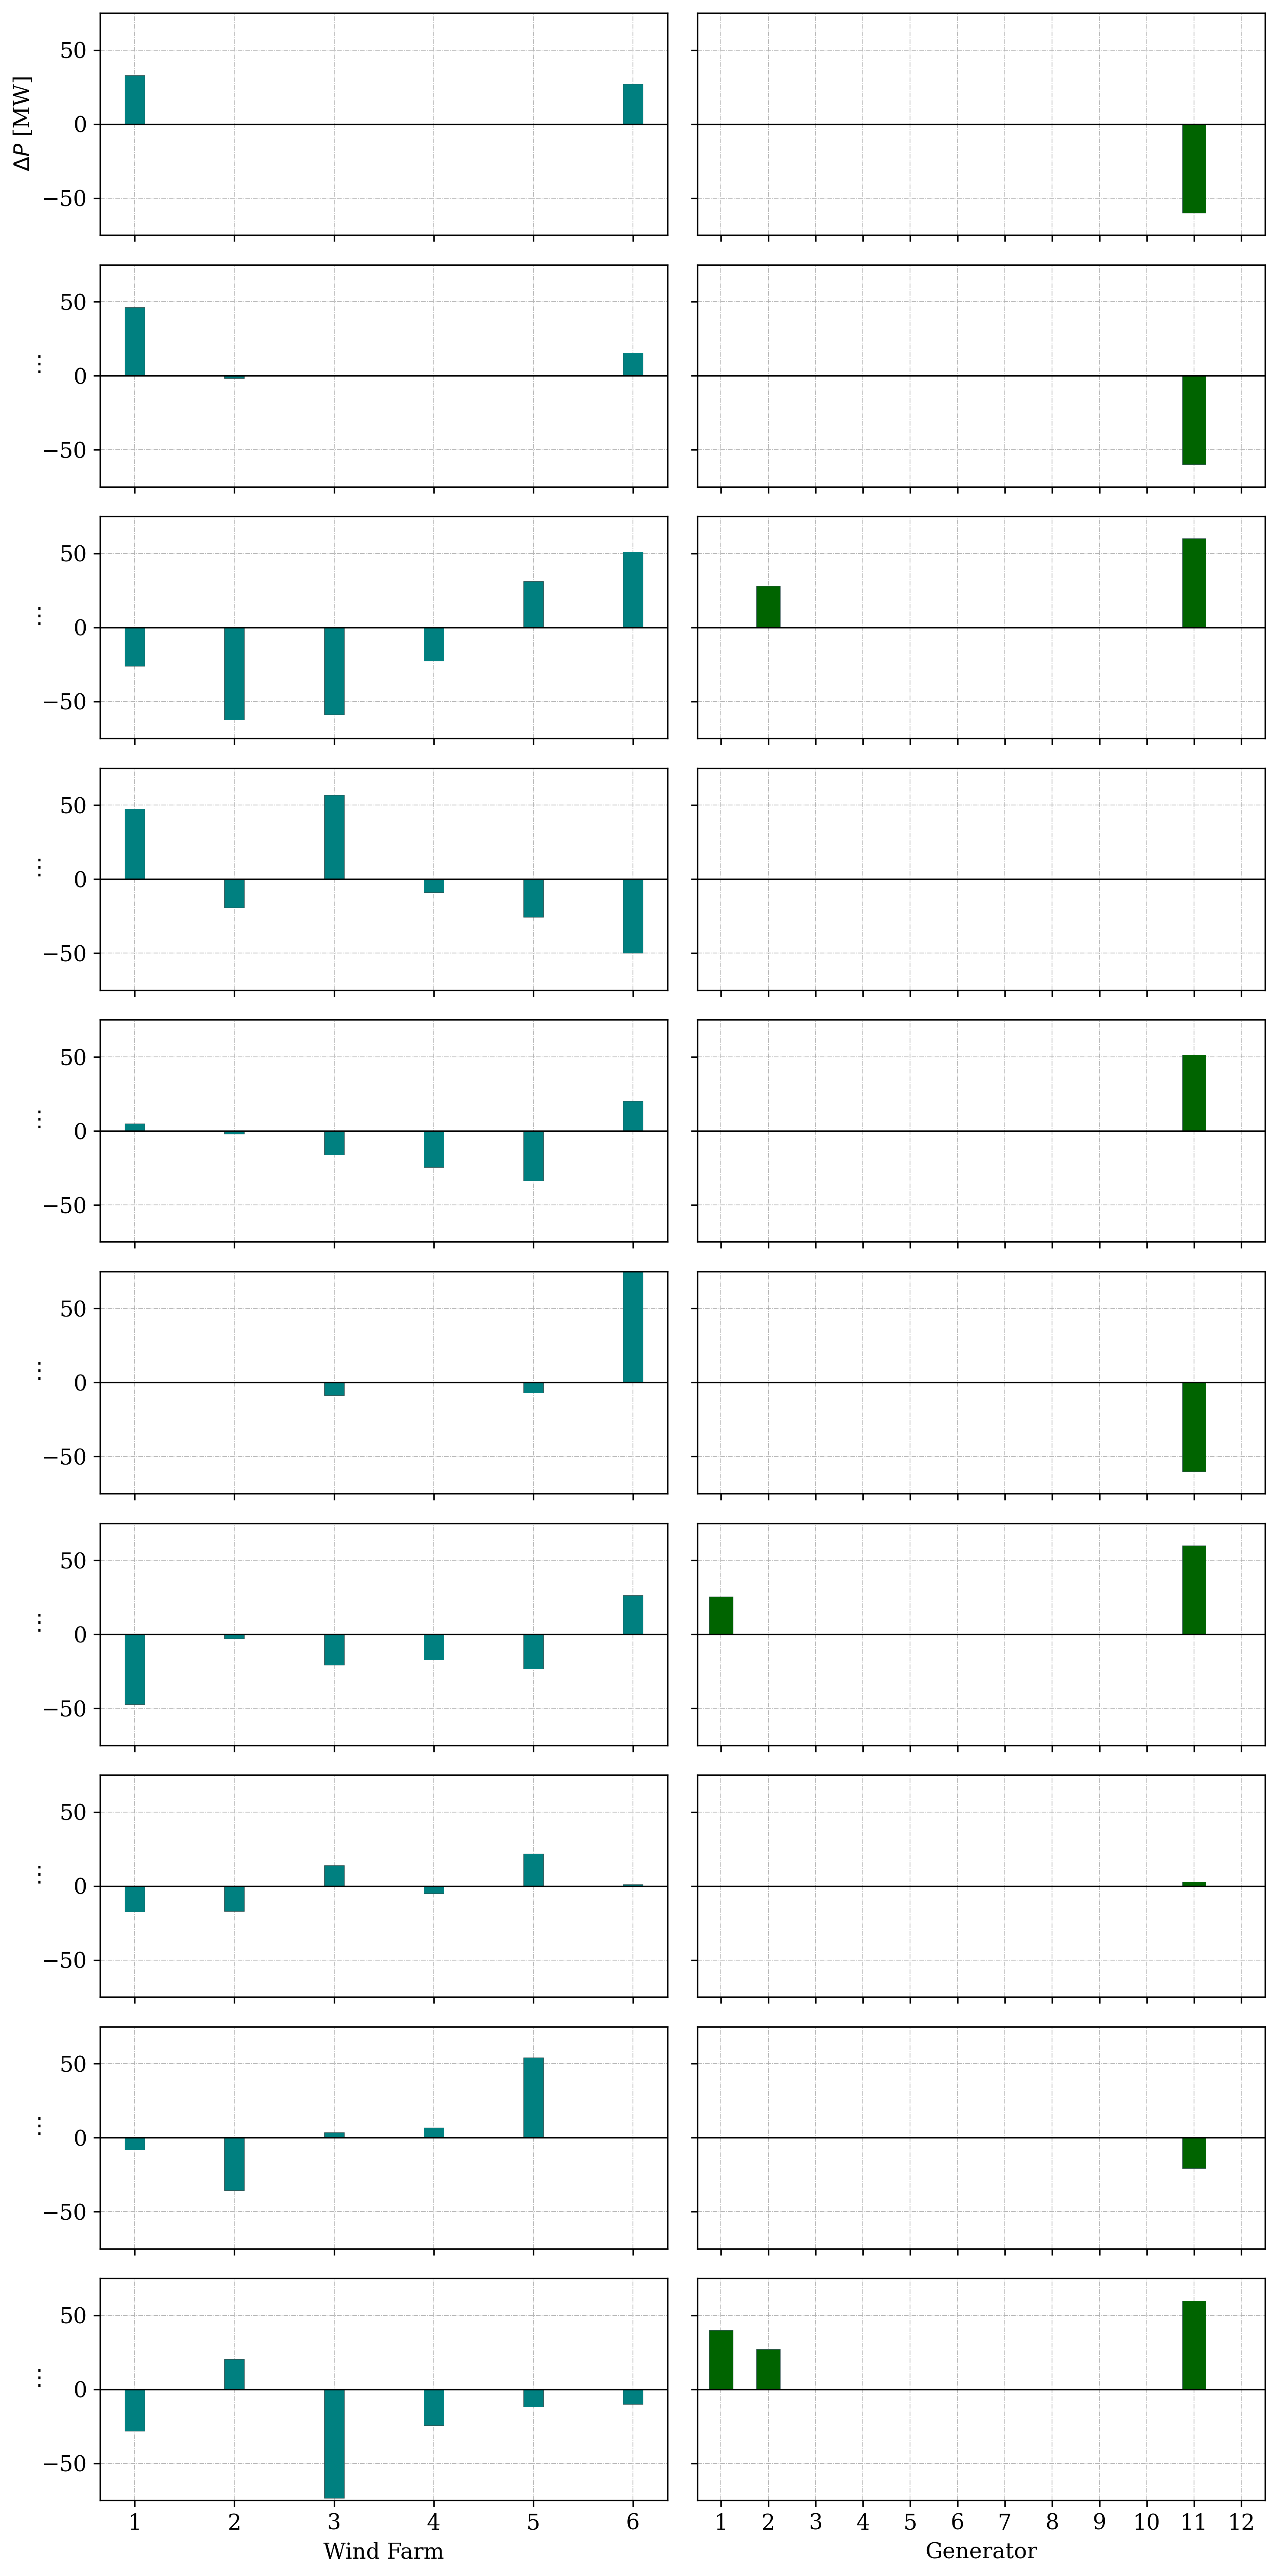

In [52]:
fig, ax = plt.subplots(10,2,sharey=True,sharex='col',figsize=( 10 , 20 ) , dpi=300) # Create the figure

for k in range(10): #how many scenarios per figure?

    (adjustment_results_scenario[k].get('wind')['p_W_ADJUST']).plot(kind='bar', ax=ax[k][0], color='teal', width=0.2, label='', edgecolor='darkslategrey',linewidth=0.2)   
    ax[k][0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
    ax[k][0].set_ylim([-75,75])

    (adjustment_results_scenario[k].get('gen')['p_G_ADJUST']).plot(kind='bar', ax=ax[k][1], color='darkgreen', label='', edgecolor='darkslategrey', linewidth=0.2)
    ax[k][1].set_ylim([-75,75])
    ax[k][1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)

    if k == 0:
        ax[k][0].set_ylabel('$\Delta P$ [MW]')
    else:
        ax[k][0].set_ylabel(r'$\vdots$', rotation=0)

    
    ax[-1][0].set_xlabel('Wind Farm')
    ax[-1][1].set_xlabel('Generator')

for i in range(10):
    for k in range(2):
        ax[i][k].axhline(0, color='black', linewidth=0.8)
        ax[i][k].spines[['right', 'top']].set_visible(True)
        ax[i][k].set_axisbelow(True)

#plt.suptitle('Objective Value: %.1f DKK\nTotal Load: %.1f MWh\nTotal Production: %.1f MWh\n(Wind: %.1f MWh & Generators: %.1f MWh)' % (m.objVal, sum_load, sum_production, sum_wind, sum_gen), fontsize=14)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/single_timestep_results.png',bbox_inches='tight')
plt.show()